In [3]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
#from codes import utils, hf, kwant_examples, model, interface, solvers
from tqdm import tqdm
from codes.model import Model
from codes.solvers import solver
from codes import kwant_examples
from codes.kwant_helper import utils
from codes.tb.transforms import tb2kfunc, kfunc2tbFFT, tb2kfunc
from codes.tb.tb import addTb
from codes.mf import fermiOnGrid

In [4]:
# Create translationally-invariant `kwant.Builder`
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()

tb_model = utils.builder2tb_model(graphene_builder)
# to make sure its hermitian
tb_model[(0, 1)] = tb_model[(0, -1)].conj().T
tb_model[(-1, 1)] = tb_model[(1, -1)].conj().T

In [5]:
params = dict(U=3.2, V=0)
filling = 2 
int_model = utils.builder2tb_model(int_builder, params)
int_model[(0, 1)] = int_model[(0, -1)].conj().T
int_model[(-1, 1)] = int_model[(1, -1)].conj().T

model = Model(tb_model, int_model, filling)
mf_guess = utils.generate_guess(tb_model, int_model)
mf_sol = solver(model, mf_guess, nK=40)

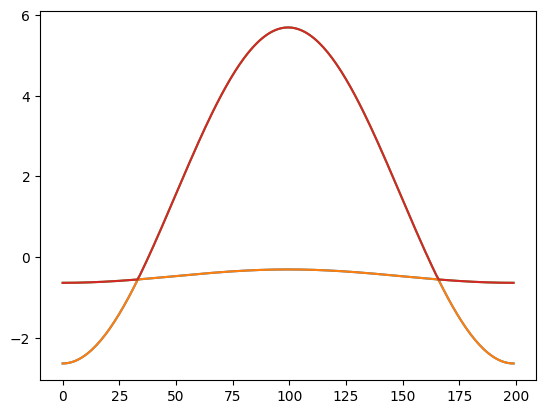

In [6]:
ks = np.linspace(-np.pi, np.pi, 200)
hkfunc = tb2kfunc(addTb(tb_model, mf_sol))
hkarray = np.array([hkfunc((kx, -kx)) for kx in ks])
vals = np.linalg.eigvalsh(hkarray)
plt.plot(vals)